In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
import glob

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sigmoid, Module, MSELoss, Linear, ReLU
from torch.optim import Adam

import torchvision
from torchvision import transforms

from PIL import Image
import cv2
import onnxruntime as ort
import onnx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class FaceDataset(Dataset):
    
    def __init__(self, image_metadata, labels, session, mode='valid'):
        self.image_metadata = image_metadata
        self.labels = labels
        self.mode = mode
#         self.random_transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(p=0.5)
#         ])
        self.input_mean = 127.5
        self.input_std = 1 / 127.5
        self.ort_session = session
            
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_metadata[idx])
        prepared_tensor = cv2.dnn.blobFromImage(image, self.input_std, (112, 112), self.input_mean, swapRB=True)
        prepared_tensor = torch.tensor(self.ort_session.run(None, {'input': prepared_tensor})[0])
        return prepared_tensor, self.labels[idx]

In [3]:
train_image_metadata = np.empty((0), dtype=str)
train_labels = np.empty((0), dtype=int)
for age_path in glob.glob('/workspace/db/train/*'):
    image_path = np.array(glob.glob(age_path + '/*.jpg'), dtype=str)
    train_image_metadata = np.append(train_image_metadata, image_path, axis=0)
    train_labels = np.append(train_labels, np.full((image_path.shape[0]), age_path.split('/')[-1]), axis=0)
train_labels = torch.tensor(train_labels.astype(int)[:, None], dtype=torch.int16)

valid_test_image_metadata = np.empty((0), dtype=str)
valid_test_labels = np.empty((0), dtype=int)
for age_path in glob.glob('/workspace/db/val/*'):
    image_path = np.array(glob.glob(age_path + '/*.jpg'), dtype=str)
    valid_test_image_metadata = np.append(valid_test_image_metadata, image_path, axis=0)
    valid_test_labels = np.append(valid_test_labels, np.full((image_path.shape[0]), age_path.split('/')[-1]), axis=0)
valid_test_labels = torch.tensor(valid_test_labels.astype(int)[:, None], dtype=torch.int16)

valid_image_metadata, test_image_metadata, valid_labels, test_labels = train_test_split(valid_test_image_metadata, valid_test_labels, test_size=0.6, random_state=42)

In [4]:
session = ort.InferenceSession('hjj_ea_e37_p20.onnx')

#load training dataset
train_dataset = FaceDataset(image_metadata=train_image_metadata, labels=train_labels, session=session, mode='train')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=16, shuffle=True)

#load valid dataset
valid_dataset = FaceDataset(image_metadata=valid_image_metadata, labels=valid_labels, session=session, mode='valid')
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=32, num_workers=16, shuffle=False)

#load test dataset
test_dataset = FaceDataset(image_metadata=test_image_metadata, labels=test_labels, session=session, mode='valid')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=16, shuffle=False)

In [5]:
class UpdatedModel(Module):
    # this class adds sigmoid activation at the end of a net
    
    def __init__(self):
        super(UpdatedModel, self).__init__()
        # changes output dim of final FC-layer from 1000 to 1
        self.fc1 = Linear(in_features=512, out_features=256) 
        self.relu = ReLU()
        self.fc2 = Linear(in_features=256, out_features=1) 

        # here we also can change model in some other way, e. freeze some layers
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [6]:
class ModelWrapper():
    
    def __init__(self, model): 
        self.model = model
        self.optimizer = Adam(self.model.parameters(), lr=0.001)
        self.loss_function = MSELoss()
        self.model.to(device)
    
    def fit(self, train_dataloader, valid_dataloader, 
            max_epoch_num=1e3, epoch_num_early_stopping=10, print_each_nth_epoch=10):
        
        # epoch_num_early_stopping = number of epochs 
        # that didn't decrease the best loss of epoch (min_epoch_loss)
        
        epoch_array = np.empty((0))
        train_loss_array = np.empty((0))
        valid_loss_array = np.empty((0))
    
        epoch = 1
        
        min_epoch_loss = np.inf
        epoch_num_without_imporovement = 0
        
        cur_epoch_time = time.time()
        
        # training by epochs
        while epoch <= max_epoch_num and epoch_num_without_imporovement<=epoch_num_early_stopping:
            
            train_epoch_loss = 0
            valid_epoch_loss = 0
#             cur_batch_time = time.time()
            # batch-wise training within an epoch
            for batch, (x, y) in enumerate(train_dataloader):

                x, y = x.to(device), y.to(device)
                
                # straightforward move
                output = self.model(x)
                loss = self.loss_function(output[:, 0], y.float())
                train_epoch_loss = (train_epoch_loss * batch + loss.item()) / (batch + 1)
                
#                 print_each_nth_batch = 1
#                 if batch%print_each_nth_batch==0:
#                     print('batch #', batch, 
#                           '   |   train_batch_loss:', loss.item(), 
#                          '   |   ', print_each_nth_batch, ' batches of ', train_dataloader.batch_size, 
#                           ' samples took', np.round(time.time() - cur_batch_time), ' s')
#                     cur_batch_time = time.time()
                
                # backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            valid_epoch_loss = self.validation_loss(valid_dataloader)
            
            epoch_array = np.append(epoch_array, epoch)
            train_loss_array = np.append(train_loss_array, train_epoch_loss)
            valid_loss_array = np.append(valid_loss_array, valid_epoch_loss)
            
            # prints losses every x epochs
            if epoch%print_each_nth_epoch==0:
                print('epoch ', epoch, 
                      '   |   train_epoch_loss:', train_epoch_loss, 
                      '   |   valid_epoch_loss:', valid_epoch_loss, 
                     '   |   ', print_each_nth_epoch, ' epochs took', np.round(time.time() - cur_epoch_time), ' s')
                cur_epoch_time = time.time()

            # increases num of epochs without decrease of validation loss        
            if valid_epoch_loss > min_epoch_loss: 
                epoch_num_without_imporovement += 1
            else: 
                min_epoch_loss = valid_epoch_loss
                epoch_num_without_imporovement = 0
                
            epoch += 1
            
        return epoch_array, train_loss_array, valid_loss_array
    
    def validation_loss(self, valid_dataloader):
        with torch.no_grad():
            valid_loss = 0
            for batch, (x, y) in enumerate(valid_dataloader):
                
                x, y = x.to(device), y.to(device)
                
                output = self.model(x)
                valid_loss = (valid_loss * batch + self.loss_function(output[:, 0], y.float()).item()) / (batch + 1)
            return valid_loss
    
    def predict(self, dataloader):
        return np.round(self.predict_proba(dataloader))

In [12]:
updated_model = torch.load('./saved/samsung_model_scripted.pt')
model_wrapper = ModelWrapper(updated_model)

# updated_model = UpdatedModel()
# model_wrapper = ModelWrapper(updated_model)
# epoch_array, train_loss_array, valid_loss_array = model_wrapper.fit(
#                 train_dataloader=train_dataloader, 
#                   valid_dataloader=valid_dataloader,
#                  max_epoch_num=50, 
#                  epoch_num_early_stopping=3,
#                 print_each_nth_epoch=1)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


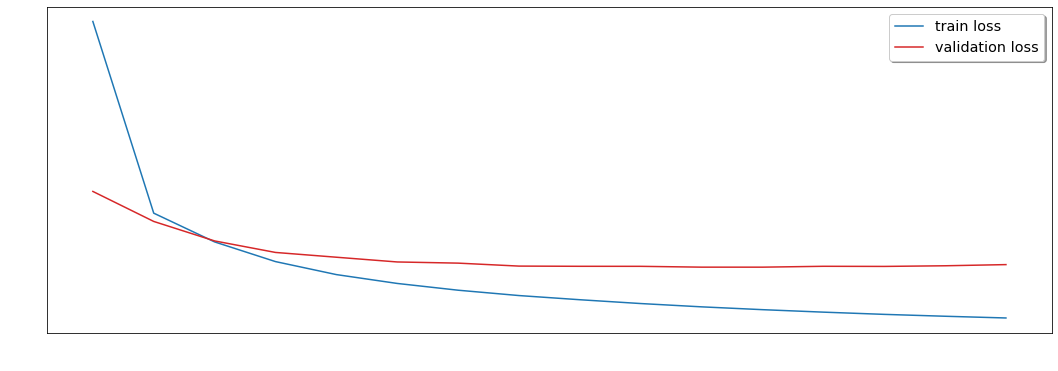

In [9]:
def plot_loss(epoch_array, train_loss_array, valid_loss_array):

    fig = plt.figure(num=1, figsize=(18,6))
    ax = fig.add_subplot(111)

    ax.plot(epoch_array, train_loss_array, color='tab:blue', label='train loss')
    ax.plot(epoch_array, valid_loss_array, color='tab:red', label='validation loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

plot_loss(epoch_array, train_loss_array, valid_loss_array)

In [15]:
# prediction = model_wrapper.predict(test_dataloader)

def predict(model_wrapper, dataloader):
    with torch.no_grad():
        prediction = torch.empty((0,1), dtype=torch.int16)
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model_wrapper.model(x)
            prediction = torch.cat((prediction, output[:, 0]), dim=0)
    return prediction
prediction = predict(model_wrapper, test_dataloader)

y_true = test_dataset.labels

print('mean_absolute_error: ', mean_absolute_error(y_true, prediction))
print('mean_squared_error: ', mean_squared_error(y_true, prediction))

mean_absolute_error:  6.804473485800452
mean_squared_error:  80.91103292284494


In [11]:
# model_scripted = torch.jit.script(model_wrapper.model)
# model_scripted.save('./saved/samsung_model_scripted.pt') 
# torch.save(model_wrapper.model, './saved/samsung_model.pt')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type UpdatedModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


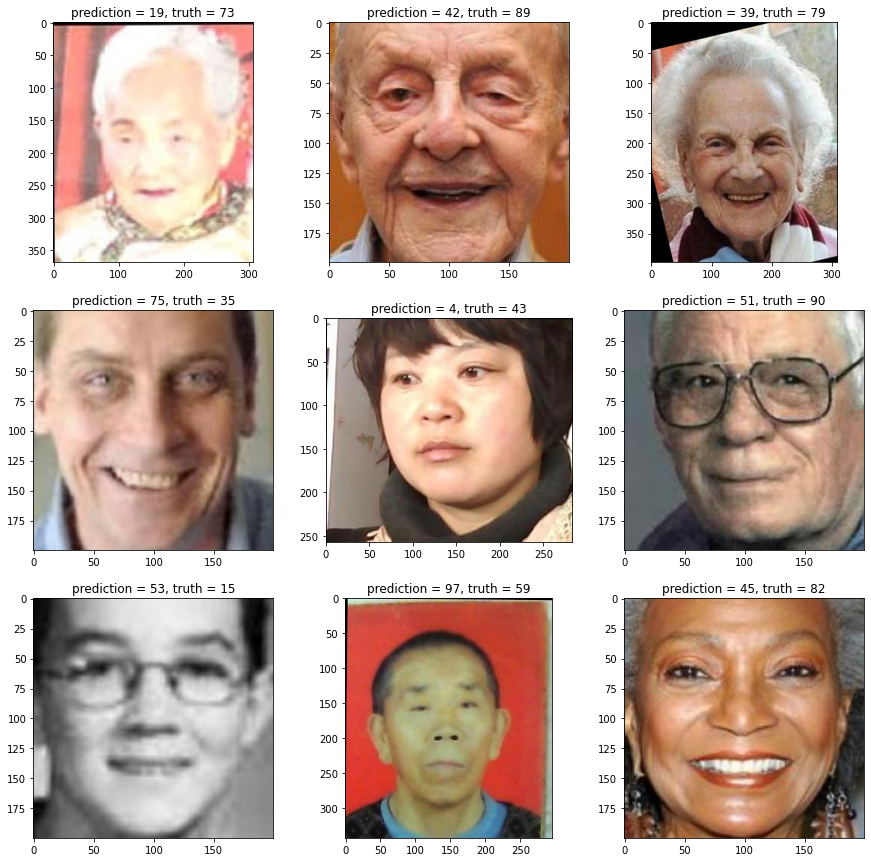

In [16]:
# выведем примеры ошибок (наибольшая разница предсказанного и реального возрастов)
n_images = 9
result_array = prediction.numpy()

result_array = np.append(result_array, y_true, axis=1)
result_array = np.append(result_array, abs(result_array[:,0] - result_array[:,1])[:, None], axis=1)
largest_faults_indices = result_array[:,-1].argsort()[::-1][:n_images]
largest_faults_ages = result_array[largest_faults_indices]
largest_faults_images = test_image_metadata[largest_faults_indices]

fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 3
for i in range(columns*rows):
    img = Image.open(largest_faults_images[i])
    ax = fig.add_subplot(rows, columns, i+1)
    ax.title.set_text('prediction = {}, truth = {}'.format(largest_faults_ages[i, 0], largest_faults_ages[i, 1]))
    plt.imshow(img)
plt.show()